Hi everyone, 

For my first kernel I wanted to analyze the "Peace Agreements Dataset", which gives us comprehensive data about every peace agreement signed since 1990. I will do an exploratory analysis of this dataset, and we will see that peace agreements are a clear indicator of the geopolitical events that occurred in the world.

Source of the dataset : *PA-X (2017). Peace Agreements Database and Access Tool, Version 1. Political Settlements Research Programme, University of Edinburgh, Edinburgh.* www.peaceagreements.org

Feel free to comment, suggest and upvote if you like this kernel !

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

pd.set_option('display.max_colwidth', None)

In [2]:
pax = pd.read_csv('./Peace Agreements Dataset/pax_20_02_2018_1_CSV.csv')
pax.head()

,Con,Contp,Reg,AgtId,Agt,Dat,Status,Lgt,Agtp,Stage,...,TjRep,TjRSym,TjRMa,TjNR,ImUN,ImOth,ImRef,ImPK,ImE,ImSrc
0,Afghanistan,Government,Europe and Eurasia,864,Tokyo Declaration Partnership for Self-Reliance in Afghanistan from Transition to Transformation (Tokyo Conference),08/07/2012,Multiparty signed/agreed,14,InterIntra,Imp,...,0,0,0,1,0,0,0,0,1,1
1,Afghanistan,Government,Europe and Eurasia,848,Conclusions of the Conference on Afghanistan and the International Community: From Transition to the Transformation Decade (Bonn Conference),05/12/2011,Multiparty signed/agreed,7,InterIntra,Pre,...,0,0,0,1,1,0,0,0,0,1
2,Afghanistan,Government,Europe and Eurasia,849,Istanbul Process on Regional Security and Cooperation for a Secure and Stable Afghanistan,02/11/2011,Multiparty signed/agreed,10,InterIntra,Imp,...,0,0,0,1,0,0,0,0,0,1
3,Afghanistan,Government,Europe and Eurasia,709,Renewed Commitment by the Afghan Government to the Afghan People and the International Community to Afghanistan (Kabul Conference Communique),22/07/2010,Multiparty signed/agreed,9,InterIntra,Imp,...,0,0,0,1,0,0,0,1,1,1
4,Afghanistan,Government,Europe and Eurasia,708,The Resolution Adopted at the Conclusion of the National Consultative Peace Jirga,06/06/2010,Multiparty signed/agreed,4,Intra,Pre,...,0,0,0,1,0,0,0,0,0,1


Over the 240 columns of the dataset, we will only use the following characteristics:
* Con: Country/Entity
* Contp: Conflict type
* Reg:  Region
* Agt: Agreement Name
* Dat: Date Signed
* Status: Agreement Definition and Status
* Lgt: Agreement length
* Agtp: Agreement type
* Stage: Agreement stage
* Cor: 1, 2 or 3 if the peace agreement includes any mention of measures to address corruption
* Terr:  1 if the peace agreement includes any reference to terror-ism, anti-terrorism measures,or terrorist activities
* SsrCrOcr: 1, 2 or 3 if the peace agreement includes any reference to crime or organised crime
* SsrDrugs: 1, 2 or 3 if the peace agreement includes any reference to (illicit) drugs and/or drug trade/trafficking

Let's now proceed to the creation of some new columns ...

In [3]:
pax['Countries involved'] = pax['Con'].apply(str.split, args = '/')

In [4]:
pax['Year'] = pax['Dat'].apply(lambda date : int(date.split('/')[2]))
pax['Month'] = pax['Dat'].apply(lambda date : int(date.split('/')[1]))
pax['Day'] = pax['Dat'].apply(lambda date : int(date.split('/')[0]))

In [5]:
pax['isCor'] = pax['Cor'] >= 1
pax['isTerr'] = pax['Terr'] >= 1
pax['isCrOcr'] = pax['SsrCrOcr'] >= 1
pax['isDrugs'] = pax['SsrDrugs'] >= 1
pax['isCrime'] = pax['isDrugs'] | pax['isCrOcr'] | pax['isTerr'] | pax['isCor']

# Study of the geography
Let's see how peace treaties differ by regions and countries.
First, which are the countries that have signed the highest number of treaties?

In [6]:
country_list = {}
for num, agreement in pax.iterrows():
    for country in agreement['Countries involved']:
        if country.strip('()') not in country_list: #What do the parenthesis mean in the DB?
            country_list[country.strip('()')] = 1
        else:
            country_list[country.strip('()')] += 1
countries_df = pd.DataFrame.from_dict(country_list, orient = 'index', columns=['Peace Treaties Signed'])

code_df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

def return_country_code(con):
    if con in code_df['COUNTRY'].values:
        return code_df[code_df['COUNTRY'] == con]['CODE'].values[0]

countries_df['Country'] = countries_df.index
countries_df['Code'] = countries_df['Country'].apply(return_country_code)
countries = countries_df.dropna()

Here I took out some territories which aren't considered as countries and which couldn't be plotted.

In [7]:
data=dict(
    type = 'choropleth',
    locations = countries['Code'],
    z = countries['Peace Treaties Signed'],
    text = countries['Country'],
    colorscale = 'YlOrRd',
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Peace Treaties Signed',
)

layout = dict(title_text='Peace Treaties since 1990',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ))

fig = go.Figure(data = [data], layout = layout)
iplot(fig)

Philippines is the country which have signed the most peace agreements since 1990, followed by Bosnia Herzegovina, Colombia and Sudan. We see that each region is "leaded" by a country that has signed a huge number of agreements.



I was surprised to see that France and Germany have signed one, here is the corresponding agreement for those interested : https://en.wikipedia.org/wiki/Treaty_on_the_Final_Settlement_with_Respect_to_Germany

Let's now look at the stages of the agreements signed and at their regional repartition:

In [8]:
def return_stage(stage):
    return pax[pax['Stage'] == stage].groupby('Reg').count()['Con']
data = []
names = ['Implementation', 'Pre-negotiation', 'Partial', 'Comprehensive', 'Ceasefire', 'Renewal', 'Others']
abb = ['Imp', 'Pre', 'SubPar', 'SubComp', 'Cea', 'Ren', 'Oth']
for i in range(len(names)):
    data.append(go.Bar(name = names[i], x = return_stage(abb[i]).index, y = return_stage(abb[i]).values))

layout = dict(barmode = 'stack')

fig = go.Figure(data=data, layout = layout)
fig.show()

From this plot, we can note several things:
* Africa has a large proportion (32%) of 'Partial' peace agreements, which deal with "some of the issues in ways that appear to contemplate future agreements to complete"
* Europe, APAC and Americas' first stage of agreements is 'Pre-negociation', meaning that they "aim to get parties to the point of negotiating over the incompatibilities at the heart of the conflict". This also illustrates the mostly "diplomatic" attitude of the European countries when dealing with conflicts.
* Most ceasefires (91%) happened in Africa, Europe and Asia
* Cross-regional agreements represent only 2% of the total agreements.

What about the mention of crimes in those treaties ?

In [9]:
layout = dict(title_text='Mentions of Crimes in Peace Treaties by region',
             barmode = 'stack')
data = [
    go.Bar(name='Corruption', x=pax[pax['isCor'] == 1].groupby('Reg').count()['Con'].index, y=pax[pax['isCor'] == 1].groupby('Reg').count()['Con'].values),
    go.Bar(name='Terrorism', x=pax[pax['isTerr'] == 1].groupby('Reg').count()['Con'].index, y=pax[pax['isTerr'] == 1].groupby('Reg').count()['Con'].values),
    go.Bar(name='Organised Crime', x=pax[pax['isCrOcr'] == 1].groupby('Reg').count()['Con'].index, y=pax[pax['isCrOcr'] == 1].groupby('Reg').count()['Con'].values),
    go.Bar(name='Drugs', x=pax[pax['isDrugs'] == 1].groupby('Reg').count()['Con'].index, y=pax[pax['isDrugs'] == 1].groupby('Reg').count()['Con'].values),
]
fig = go.Figure(data=data, layout = layout)
fig.show()

This plot illustrates what are the biggest problem for the authorities in each continent: Corruption for Africa, Terrorism for Europe and MiddleEast/North Africa, and Drugs in America.

In [10]:
layout = dict(title_text='Length of Peace Treaties by region',
             barmode = 'stack')
data = [
    go.Bar(name='Less than 2 pages', x=pax[pax['Lgt'] <= 2].groupby('Reg').count()['Con'].index, y=pax[pax['Lgt'] <= 2].groupby('Reg').count()['Con'].values),
    go.Bar(name='Between 2 and 6 pages', x=pax[(pax['Lgt'] > 2) & (pax['Lgt'] <= 6)].groupby('Reg').count()['Con'].index, y=pax[(pax['Lgt'] > 2) & (pax['Lgt'] <= 6)].groupby('Reg').count()['Con'].values),
    go.Bar(name='More than 6 pages', x=pax[pax['Lgt'] > 6].groupby('Reg').count()['Con'].index, y=pax[pax['Lgt'] > 6].groupby('Reg').count()['Con'].values)
]
fig = go.Figure(data=data, layout = layout)
fig.show()

I chose such categories as 2 and 6 are the quartiles of the length of the agreeements.

We see that peace seems to be easier to express in Europe and harder in Africa.

In [11]:
pax[pax['Lgt'] > 6]
country_list = {}
for num, agreement in pax[pax['Lgt'] > 6].iterrows():
    for country in agreement['Countries involved']:
        if country.strip('()') not in country_list: 
            country_list[country.strip('()')] = 1
        else:
            country_list[country.strip('()')] += 1
countries_df = pd.DataFrame.from_dict(country_list, orient = 'index', columns=['Long Peace Treaties Signed'])

countries_df['Country'] = countries_df.index
countries_df['Code'] = countries_df['Country'].apply(return_country_code)
countries = countries_df.dropna()
data=dict(
    type = 'choropleth',
    locations = countries['Code'],
    z = countries['Long Peace Treaties Signed'],
    text = countries['Country'],
    colorscale = 'YlOrRd',
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Long Peace Treaties Signed',
)

layout = dict(title_text='Countries that have signed long Peace Treaties since 1990',
              geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ))

fig = go.Figure(data = [data], layout = layout)
iplot(fig)

As compared to the first chloropleth map, we see that now it's Sudan and South Sudan that have signed the most long peace agreements. This may show how complex the situation is in this region.

# Study of the time period
Let's now try to identify some trends and differences in the peace treaties since 1990.

Text(0.5, 1.0, 'Peace agreements per month')

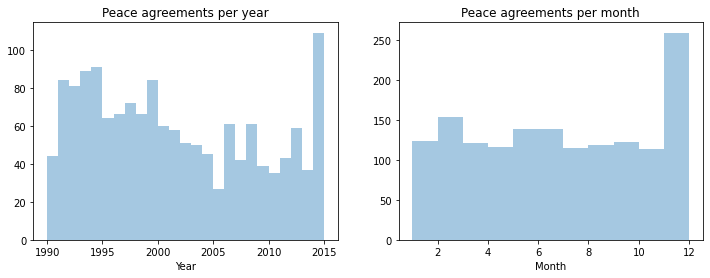

In [12]:
plt.figure(figsize = (12,4))
plt.subplot(121)
sns.distplot(pax['Year'], kde = False, bins = 25).set_title('Peace agreements per year')
plt.subplot(122)
sns.distplot(pax['Month'], kde = False).set_title('Peace agreements per month')

Let's note that 2015 has had the highest number of peace treaties signed.
Surprisingly, we see that the month of December has almost twice more agreements signed than any other month of the year !

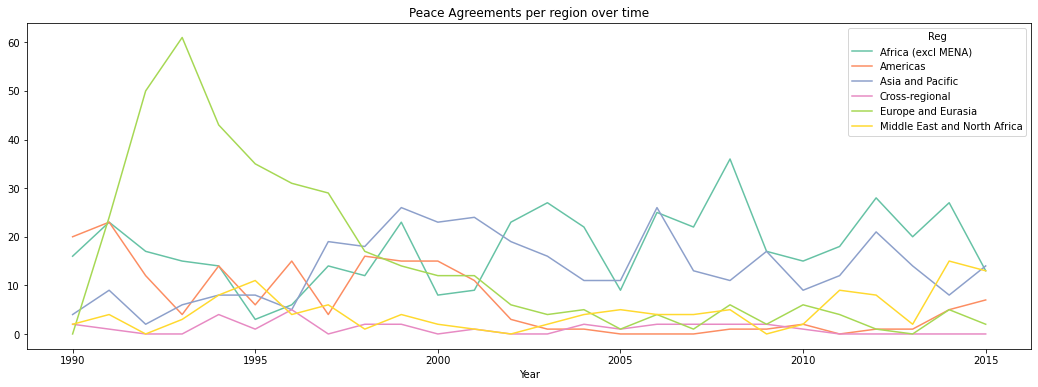

In [13]:
regions_evolution = pd.crosstab(pax.Year,pax.Reg)
regions_evolution.plot(color=sns.color_palette('Set2',12), title='Peace Agreements per region over time')
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.show()

An interesting curve is the European one. In this region, a lot of conflicts ceased in the 90's (mostly balkanic wars, or conflicts between Eastern and Western Europe), while after that, a very low number of agreements have been signed, due to a lower number of conflicts in that region.

In [14]:
layout = dict(title_text='Mentions of Crime in Peace Treaties over time',
             barmode = 'stack')
data = [
    go.Bar(name='Corruption', x=pax[pax['isCor'] == 1].groupby('Year').count()['Con'].index, y=pax[pax['isCor'] == 1].groupby('Year').count()['Con'].values),
    go.Bar(name='Terrorism', x=pax[pax['isTerr'] == 1].groupby('Year').count()['Con'].index, y=pax[pax['isTerr'] == 1].groupby('Year').count()['Con'].values),
    go.Bar(name='Organised Crime', x=pax[pax['isCrOcr'] == 1].groupby('Year').count()['Con'].index, y=pax[pax['isCrOcr'] == 1].groupby('Year').count()['Con'].values),
    go.Bar(name='Drugs', x=pax[pax['isDrugs'] == 1].groupby('Year').count()['Con'].index, y=pax[pax['isDrugs'] == 1].groupby('Year').count()['Con'].values),
]
fig = go.Figure(data=data, layout = layout)
fig.show()

Here I can't find any pattern here, but we see that the crimes mentioned in peace treaties change very quickly over time.

# Some special agreements

In [15]:
# Agreements with the largest number of countries involved
max = 0
for num, agreement in pax.iterrows():
    if len(agreement['Countries involved']) >= max:
        max = len(agreement['Countries involved'])
pax[pax['Countries involved'].apply(len) == max]

,Con,Contp,Reg,AgtId,Agt,Dat,Status,Lgt,Agtp,Stage,...,ImSrc,Countries involved,Year,Month,Day,isCor,isTerr,isCrOcr,isDrugs,isCrime
37,Angola/Burundi/Central African Republic/Democratic Republic of Congo/Kenya/Republic of Congo/Rwanda/Sudan/Tanzania/Uganda/Zambia/(African Great Lakes),Government,Africa (excl MENA),668,"Pact on Security, Stability, and Development in the Great Lakes Region",15/12/2006,Multiparty signed/agreed,25,InterIntra,Imp,...,1,"[Angola, Burundi, Central African Republic, Democratic Republic of Congo, Kenya, Republic of Congo, Rwanda, Sudan, Tanzania, Uganda, Zambia, (African Great Lakes)]",2006,12,15,False,True,False,False,True
38,Angola/Burundi/Central African Republic/Democratic Republic of Congo/Kenya/Republic of Congo/Rwanda/Sudan/Tanzania/Uganda/Zambia/(African Great Lakes),Government,Africa (excl MENA),349,"Dar-Es-Salaam Declaration on Peace, Security, Democracy and Development in the Great Lakes Region",20/11/2004,Multiparty signed/agreed,13,InterIntra,SubPar,...,1,"[Angola, Burundi, Central African Republic, Democratic Republic of Congo, Kenya, Republic of Congo, Rwanda, Sudan, Tanzania, Uganda, Zambia, (African Great Lakes)]",2004,11,20,False,True,False,False,True
39,Angola/Burundi/Central African Republic/Democratic Republic of Congo/Republic of Congo/Rwanda/South Africa/South Sudan/Tanzania/Uganda/Zambia/(African Great Lakes),Government,Africa (excl MENA),789,"Peace, Security and Cooperation Framework for the Democratic Republic of the Congo and the region\r\n",24/02/2013,Multiparty signed/agreed,8,InterIntra,Imp,...,1,"[Angola, Burundi, Central African Republic, Democratic Republic of Congo, Republic of Congo, Rwanda, South Africa, South Sudan, Tanzania, Uganda, Zambia, (African Great Lakes)]",2013,2,24,False,False,False,False,False


In [16]:
#Longest agreement in number of pages
max = 0
for num, agreement in pax.iterrows():
    if agreement['Lgt'] >= max:
        max = agreement['Lgt']
pax[pax['Lgt'] == max]

,Con,Contp,Reg,AgtId,Agt,Dat,Status,Lgt,Agtp,Stage,...,ImSrc,Countries involved,Year,Month,Day,isCor,isTerr,isCrOcr,isDrugs,isCrime
1332,South Sudan/Sudan,Government/territory,Africa (excl MENA),337,Comprehensive Peace Agreement between the Government of the Republic of the Sudan and the Sudan People's Liberation Army/Sudan People's Liberation Movement (Naivasha Agreement),09/01/2005,Multiparty signed/agreed,245,Intra,SubComp,...,1,"[South Sudan, Sudan]",2005,1,9,True,True,True,True,True


Information on that agreement can be found at https://en.wikipedia.org/wiki/Comprehensive_Peace_Agreement

Once again, we see how peace was hard to express between Sudan and South Sudan.